In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}



#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# calculate rank correlations + plot

In [3]:
def calc_rank_corr_two_methods(attr1, attr2):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate feature ranks
    ranks1 = np.argsort(-np.abs(attr1), axis=1)
    ranks2 = np.argsort(-np.abs(attr2), axis=1)

    #calculate rank correlation for each data point
    #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
    corrs = []
    for row in range(ranks1.shape[0]):
        rho, _ = spearmanr(ranks1[row, :], ranks2[row, :])
        corrs.append(rho)
        
    return np.array(corrs) #rank correlations for each datapoint




In [4]:
def calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs):
    
    #initiate correlation matrix
    num_expl_methods = len(expl_methods_attrs)
    corr_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill correlation matrix with average rank correlation
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        corrs = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b]) #rank correlations for each datapoint
        corr_matrix[a, b] = np.mean(corrs) #average rank correlation
        corr_matrix[b, a] = corr_matrix[a, b]
        
    return corr_matrix
    
    

In [5]:
def plot_corr_matrix(corr_matrix, plot_path, 
                     labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels,
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.savefig(plot_path, facecolor='white', transparent=False)

In [6]:
#combine both functions
def rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path, 
                              labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    corr_matrix = calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs)
    plot_corr_matrix(corr_matrix, plot_path, labels)
    
    return corr_matrix

### NN

calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating LIME (0) and Grad (2)
calculating LIME (0) and Grad*Input (3)
calculating LIME (0) and IntGrad (4)
calculating LIME (0) and SmoothGRAD (5)
calculating KernelSHAP (1) and KernelSHAP (1)
calculating KernelSHAP (1) and Grad (2)
calculating KernelSHAP (1) and Grad*Input (3)
calculating KernelSHAP (1) and IntGrad (4)
calculating KernelSHAP (1) and SmoothGRAD (5)
calculating Grad (2) and Grad (2)
calculating Grad (2) and Grad*Input (3)
calculating Grad (2) and IntGrad (4)
calculating Grad (2) and SmoothGRAD (5)
calculating Grad*Input (3) and Grad*Input (3)
calculating Grad*Input (3) and IntGrad (4)
calculating Grad*Input (3) and SmoothGRAD (5)
calculating IntGrad (4) and IntGrad (4)
calculating IntGrad (4) and SmoothGRAD (5)
calculating SmoothGRAD (5) and SmoothGRAD (5)


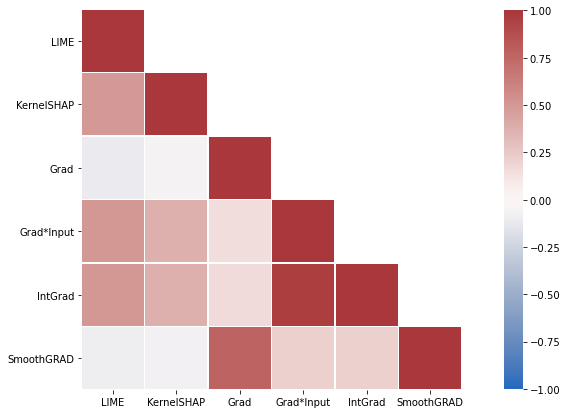

In [7]:
#arguments
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
m='nn'
expl_methods_attrs = {0: attr_lime[m],
                      1: attr_kernelshap[m], 
                      2: attr_vanillagrad[m],
                      3: attr_gradtinput[m],
                      4: attr_integratedgrad[m],
                      5: attr_smoothgrad[m]}
plot_path=f'figures/rank_correlation_{m}.png'

#calculate + plot rank correlation
corr_matrix_nn = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path)


In [8]:
corr_matrix_nn

array([[ 1.        ,  0.49616831, -0.11321573,  0.50660305,  0.50612107,
        -0.10094949],
       [ 0.49616831,  1.        , -0.05643917,  0.37550607,  0.37950646,
        -0.076417  ],
       [-0.11321573, -0.05643917,  1.        ,  0.15370156,  0.1566898 ,
         0.77552053],
       [ 0.50660305,  0.37550607,  0.15370156,  1.        ,  0.96609312,
         0.21737035],
       [ 0.50612107,  0.37950646,  0.1566898 ,  0.96609312,  1.        ,
         0.21859938],
       [-0.10094949, -0.076417  ,  0.77552053,  0.21737035,  0.21859938,
         1.        ]])

### logistic

calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating LIME (0) and Grad (2)
calculating LIME (0) and Grad*Input (3)
calculating LIME (0) and IntGrad (4)
calculating LIME (0) and SmoothGRAD (5)
calculating KernelSHAP (1) and KernelSHAP (1)
calculating KernelSHAP (1) and Grad (2)
calculating KernelSHAP (1) and Grad*Input (3)
calculating KernelSHAP (1) and IntGrad (4)
calculating KernelSHAP (1) and SmoothGRAD (5)
calculating Grad (2) and Grad (2)
calculating Grad (2) and Grad*Input (3)
calculating Grad (2) and IntGrad (4)
calculating Grad (2) and SmoothGRAD (5)
calculating Grad*Input (3) and Grad*Input (3)
calculating Grad*Input (3) and IntGrad (4)
calculating Grad*Input (3) and SmoothGRAD (5)
calculating IntGrad (4) and IntGrad (4)
calculating IntGrad (4) and SmoothGRAD (5)
calculating SmoothGRAD (5) and SmoothGRAD (5)


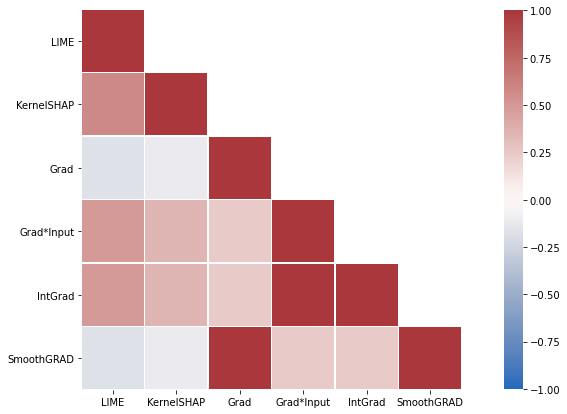

In [9]:
#arguments
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
m='nn_logistic'
expl_methods_attrs = {0: attr_lime[m],
                      1: attr_kernelshap[m], 
                      2: attr_vanillagrad[m],
                      3: attr_gradtinput[m],
                      4: attr_integratedgrad[m],
                      5: attr_smoothgrad[m]}
plot_path=f'figures/rank_correlation_{m}.png'

#calculate + plot rank correlation
corr_matrix_nn_logistic = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path)



In [10]:
corr_matrix_nn_logistic

array([[ 1.        ,  0.57569404, -0.16469057,  0.48942067,  0.48942067,
        -0.16469057],
       [ 0.57569404,  1.        , -0.11270966,  0.34598516,  0.34598516,
        -0.11270966],
       [-0.16469057, -0.11270966,  1.        ,  0.24587912,  0.24587912,
         1.        ],
       [ 0.48942067,  0.34598516,  0.24587912,  1.        ,  1.        ,
         0.24587912],
       [ 0.48942067,  0.34598516,  0.24587912,  1.        ,  1.        ,
         0.24587912],
       [-0.16469057, -0.11270966,  1.        ,  0.24587912,  0.24587912,
         1.        ]])

### RF

calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)


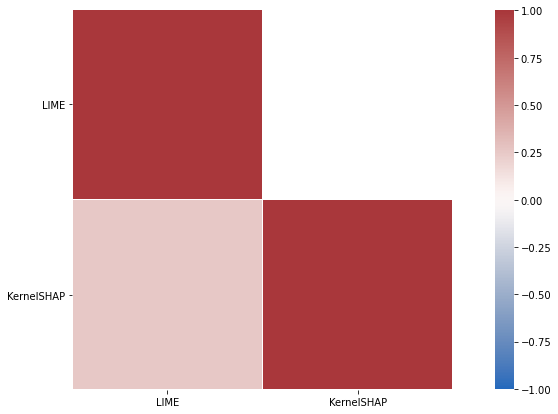

In [11]:
#arguments
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
m='rf'
expl_methods_attrs = {0: attr_lime[m],
                      1: attr_kernelshap[m]}
plot_path=f'figures/rank_correlation_{m}.png'
labels=['LIME', 'KernelSHAP']

#calculate + plot rank correlation
corr_matrix_rf = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path, labels)



In [12]:
corr_matrix_rf

array([[1.        , 0.25139773],
       [0.25139773, 1.        ]])

### GB

calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating KernelSHAP (1) and KernelSHAP (1)


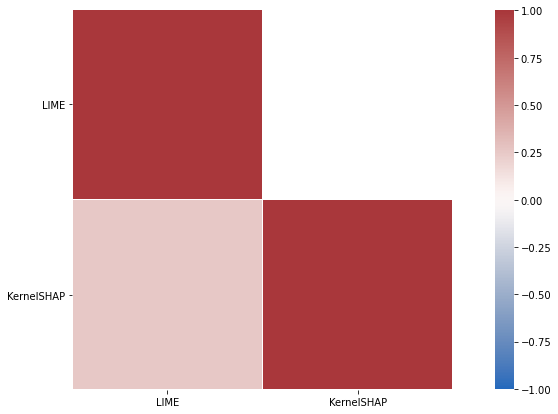

In [13]:
#arguments
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
m='gb'
expl_methods_attrs = {0: attr_lime[m],
                      1: attr_kernelshap[m]}
plot_path=f'figures/rank_correlation_{m}.png'
labels=['LIME', 'KernelSHAP']

#calculate + plot rank correlation
corr_matrix_gb = rank_correlation_analysis(expl_methods_names, expl_methods_attrs, plot_path, labels)


In [14]:
corr_matrix_gb

array([[1.        , 0.25547041],
       [0.25547041, 1.        ]])